In [1]:
import pickle
import os
import pandas as pd
import pandana as pdn
import numpy as np
import folium

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

from geopy.distance import geodesic

import json
import math

from datetime import datetime, timedelta

import datetime

import osmnx as ox
import networkx as nx

In [2]:
a = [1, 0.7, 0.4, 0.1, 0]
b = [1, 0.8, 0.6, 0.4]

def calcular_distancia(row):
    # Convertir de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [row['O_lat'], row['O_long'], row['D_lat'], row['D_long']])
    
    # Diferencia de las coordenadas
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Fórmula de Haversine
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # 6371 km es el radio promedio de la Tierra
    distancia_km = 6371 * c
    return distancia_km

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    distance = distance*1000
    return distance

# DRIVE

networks = dict.fromkeys({
 "walk",
 "drive",
})

for k in networks:
    # print(k)
    networks[k] = pdn.network.Network.from_hdf5(f'networks/{k}_net.h5')

# # TRANSIT

transit = dict.fromkeys({
 "transit_0001",
 "transit_0102",
 "transit_0203", # walk_network because transit is not available
 "transit_0304", # walk_network because transit is not available
 "transit_0405", # walk_network because transit is not available
 "transit_0506",
 "transit_0607",
 "transit_0708",
 "transit_0809",
 "transit_0910",
 "transit_1011",
 "transit_1112",
 "transit_1213",
 "transit_1314",
 "transit_1415",
 "transit_1516",
 "transit_1617",
 "transit_1718",
 "transit_1819",
 "transit_1920",
 "transit_2021",
 "transit_2122",
 "transit_2223",
 "transit_2324",
})

for k in transit:
    # print(k)
    transit[k] = pdn.network.Network.from_hdf5(f'transit_together_24h/{k}.h5')


model_name = "rf_prueba"  # El nombre del modelo que guardaste anteriormente
file_path = os.path.join("models", f'{model_name}.pkl')

with open(file_path, 'rb') as file:
    model = pickle.load(file)

origins = pd.read_csv('origins.csv')
origins.rename(columns={'D_lat': 'O_lat', 'D_long': 'O_long'}, inplace=True)

In [3]:
# The dataset has 2500 rows
# 50% can work remotely
# 0 wfm days: 0%
# 1 wfm days: 10%
# 2 wfm days: 20%
# 5 wfm days: 50%, everyone that could wfm

wfm = [0, 1, 2, 3, 4]

aux = pd.read_csv('workers_eskuzaitzeta_2k.csv')
longitud = len(aux)
ten_percent = math.ceil(0.1 * longitud)

trips_ez_wfm_0 = pd.read_csv('workers_eskuzaitzeta_2k.csv')
trips_ez_wfm_1 =  trips_ez_wfm_0.sample(n=(longitud - (1 * ten_percent)))
trips_ez_wfm_2 =  trips_ez_wfm_1.sample(n=(longitud - (1 * 2*ten_percent)))
trips_ez_wfm_3 =  trips_ez_wfm_2.sample(n=(longitud - (1 * 3*ten_percent)))
trips_ez_wfm_4 =  trips_ez_wfm_3.sample(n=(longitud - (1 * 4*ten_percent)))

In [4]:
# TRIPS LAYER

# DRIVE NETWORK

# Configurar osmnx
ox.config(use_cache=True, log_console=True)

# Cargar la red de carreteras para la región de interés
G_D = ox.graph_from_place('Gipuzkoa', network_type='drive', simplify=True)

G_undirected_D = nx.to_undirected(G_D)
G_bidirectional_D = nx.to_networkx_graph(G_undirected_D, create_using=nx.MultiDiGraph)

nodes_D, edges_D = ox.graph_to_gdfs(G_D)
nodes_D = nodes_D.reset_index(drop=False)

coords_D = nodes_D.set_index('osmid')[['x', 'y']].T.apply(tuple).to_dict()

# Agregar las coordenadas como atributos a los nodos en el grafo G
nx.set_node_attributes(G_D, coords_D, 'coords')

# WALK NETWORK

ox.config(use_cache=True, log_console=True)

# Cargar la red de carreteras para la región de interés
G_W = ox.graph_from_place('Gipuzkoa', network_type='walk', simplify=True)

G_undirected_W = nx.to_undirected(G_W)
G_bidirectional_W = nx.to_networkx_graph(G_undirected_W, create_using=nx.MultiDiGraph)

nodes_W, edges_W = ox.graph_to_gdfs(G_W)
nodes_W = nodes_W.reset_index(drop=False)

coords_W = nodes_W.set_index('osmid')[['x', 'y']].T.apply(tuple).to_dict()

# Agregar las coordenadas como atributos a los nodos en el grafo G
nx.set_node_attributes(G_W, coords_W, 'coords')

C:\Users\iazka\AppData\Local\Temp\ipykernel_18224\2352378906.py:6: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)
C:\Users\iazka\AppData\Local\Temp\ipykernel_18224\2352378906.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


In [5]:
def calculate_segment_info_D(route, departure_time, travel_time):
    segments = []
    time_value = datetime.datetime.strptime(departure_time, '%H:%M')
    current_time = time_value.hour * 3600 + time_value.minute * 60
    time_delta = travel_time * 60 / len(route)
    current_time -= time_delta

    for i in range(len(route)-1):
        start_node = route[i]
        current_time += time_delta
        start_coords = G_D.nodes[start_node]['coords']
        segments.append([start_coords['x'], start_coords['y'], current_time])

    current_time += time_delta    
    end_coords = G_D.nodes[route[-1]]['coords']
    segments.append([end_coords['x'], end_coords['y'], current_time])

    reversed_segments = []
    for i, segment in enumerate(segments[::-1]):
        new_time = segments[i][2]  
        reversed_segments.append([segment[0], segment[1], new_time])

    return reversed_segments

def calculate_segment_info_W(route, departure_time, travel_time):
    segments = []
    time_value = datetime.datetime.strptime(departure_time, '%H:%M')
    current_time = time_value.hour * 3600 + time_value.minute * 60
    time_delta = travel_time * 60 / len(route)
    current_time -= time_delta

    for i in range(len(route)-1):
        start_node = route[i]
        current_time += time_delta
        start_coords = G_W.nodes[start_node]['coords']
        segments.append([start_coords['x'], start_coords['y'], current_time])

    current_time += time_delta    
    end_coords = G_W.nodes[route[-1]]['coords']
    segments.append([end_coords['x'], end_coords['y'], current_time])

    reversed_segments = []
    for i, segment in enumerate(segments[::-1]):
        new_time = segments[i][2] 
        reversed_segments.append([segment[0], segment[1], new_time])

    return reversed_segments

In [6]:
for remote in wfm:
    if remote == 0:
        workers = trips_ez_wfm_0
    elif remote == 1:
        workers = trips_ez_wfm_1
    elif remote == 2:
        workers = trips_ez_wfm_2
    elif remote == 3:
        workers = trips_ez_wfm_3
    else:
        workers = trips_ez_wfm_4   
        
    for valor in a:

        # Bring trips
        trips_ez = workers

        eliminar = ['Unnamed: 0', 'Com_Ori', 'Com_Des', 'Modo', 'Municipio', 'Motos','Actividad','Año']
        trips_ez = trips_ez.drop(columns=eliminar)

        trips_ez['Hora_Ini_E'] = trips_ez['Hora_Ini'].copy()
        cols = list(trips_ez.columns)
        A_index = cols.index('Hora_Ini')
        cols = cols[:A_index+1] + ['Hora_Ini_E'] + cols[A_index+1:-1]
        trips_ez = trips_ez[cols]

        trips_ez['Hora_Ini'] = pd.to_datetime(trips_ez['Hora_Ini_E'], format='%H:%M') # Probably the first is Hora_Ini_E

        trips_ez['Hora_Ini_E'] = ((trips_ez['Hora_Ini'] - pd.to_datetime('00:00', format='%H:%M')).dt.total_seconds() / 300).astype(int) + 1
        trips_ez['Hora_Ini'] = trips_ez['Hora_Ini'].dt.strftime('%H:%M')

        # Aplicar la función a cada fila
        trips_ez['distancia'] = trips_ez.apply(calcular_distancia, axis=1)
        trips_ez['distancia'] = trips_ez['distancia'] * 1000

        if valor == 0:
            def generar_punto_dentro_circulo(centro_lat, centro_long, radio):
                # Generar ángulo aleatorio
                angulo = np.random.uniform(0, 2 * np.pi)
                
                # Generar distancia aleatoria desde el centro
                # Usar la raíz cuadrada para asegurar una distribución uniforme dentro del círculo
                distancia = np.sqrt(np.random.uniform(0, 1)) * radio
                
                # Convertir polar a cartesiano
                delta_lat = distancia * np.cos(angulo)
                delta_long = distancia * np.sin(angulo)
                
                # Calcular las nuevas coordenadas
                punto_lat = centro_lat + delta_lat
                punto_long = centro_long + delta_long
                
                return punto_lat, punto_long

            # Ejemplo de uso	
            centro_lat = 43.256347
            centro_long = -2.033693
            radio = 0.005

            for index, row in trips_ez.iterrows():
                lat, long = generar_punto_dentro_circulo(centro_lat, centro_long, radio)
                trips_ez.at[index, 'O_lat'] = lat
                trips_ez.at[index, 'O_long'] = long
        else:
            # Su porcentaje
            trips_ez['distancia'] = trips_ez['distancia'] * valor

            # Assign NEW origin
            trips_ez['O_lat'] = np.nan
            trips_ez['O_long'] = np.nan

            for index, row in trips_ez.iterrows():
                distances = haversine(row['D_lat'], row['D_long'], origins['O_lat'], origins['O_long'])
                
                within_range = origins[(distances <= row['distancia'] * 1.2) & (distances >= row['distancia'] * 0.8)]
            
                if not within_range.empty:
                    chosen = within_range.sample(n=1)
                    trips_ez.at[index, 'O_lat'] = chosen['O_lat'].values[0]
                    trips_ez.at[index, 'O_long'] = chosen['O_long'].values[0]

        trips_ez = trips_ez.drop(columns='distancia')
        
        trips_ez = trips_ez.dropna(subset=['O_lat']).reset_index(drop=True)

        # TRAVEL TIMES

        trips_ez["drive_tt"] = networks['drive'].shortest_path_lengths(
                    networks['drive'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
                    networks['drive'].get_node_ids(trips_ez.D_long,trips_ez.D_lat),
                    imp_name='drive_time_s'
                    )
        trips_ez["drive_tt"] = trips_ez["drive_tt"] / 60 # To min

        trips_ez["distance"] = networks['drive'].shortest_path_lengths(
                    networks['drive'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
                    networks['drive'].get_node_ids(trips_ez.D_long,trips_ez.D_lat),
                    imp_name='distance'
                    )

        trips_ez["walk_tt"] = networks['walk'].shortest_path_lengths(
                    networks['walk'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
                    networks['walk'].get_node_ids(trips_ez.D_long,trips_ez.D_lat)
                    )
        trips_ez["walk_tt"] = trips_ez["walk_tt"] / 60

        # Add TRANSIT

        for k in transit:
            trips_ez[f"{k}_tt"] = transit[k].shortest_path_lengths(
                    transit[k].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
                    transit[k].get_node_ids(trips_ez.D_long,trips_ez.D_lat)
            )

        def asignar_valor(row):
            if 1 <= row['Hora_Ini_E'] <= 12:
                return row['transit_0001_tt']
            elif 13 <= row['Hora_Ini_E'] <= 24:
                return row['transit_0102_tt']
            elif 25 <= row['Hora_Ini_E'] <= 36:
                return row['transit_0203_tt']
            elif 37 <= row['Hora_Ini_E'] <= 48:
                return row['transit_0304_tt']
            elif 49 <= row['Hora_Ini_E'] <= 60:
                return row['transit_0405_tt']
            elif 61 <= row['Hora_Ini_E'] <= 72:
                return row['transit_0506_tt']
            elif 73 <= row['Hora_Ini_E'] <= 84:
                return row['transit_0607_tt']
            elif 85 <= row['Hora_Ini_E'] <= 96:
                return row['transit_0708_tt']
            elif 97 <= row['Hora_Ini_E'] <= 108:
                return row['transit_0809_tt']
            elif 109 <= row['Hora_Ini_E'] <= 120:
                return row['transit_0910_tt']
            elif 121 <= row['Hora_Ini_E'] <= 132:
                return row['transit_1011_tt']
            elif 133 <= row['Hora_Ini_E'] <= 144:
                return row['transit_1112_tt']
            elif 145 <= row['Hora_Ini_E'] <= 156:
                return row['transit_1213_tt']
            elif 157 <= row['Hora_Ini_E'] <= 168:
                return row['transit_1314_tt']
            elif 169 <= row['Hora_Ini_E'] <= 180:
                return row['transit_1415_tt']
            elif 181 <= row['Hora_Ini_E'] <= 192:
                return row['transit_1516_tt']
            elif 193 <= row['Hora_Ini_E'] <= 204:
                return row['transit_1617_tt']
            elif 205 <= row['Hora_Ini_E'] <= 216:
                return row['transit_1718_tt']
            elif 217 <= row['Hora_Ini_E'] <= 228:
                return row['transit_1819_tt']
            elif 229 <= row['Hora_Ini_E'] <= 240:
                return row['transit_1920_tt']
            elif 241 <= row['Hora_Ini_E'] <= 252:
                return row['transit_2021_tt']
            elif 253 <= row['Hora_Ini_E'] <= 264:
                return row['transit_2122_tt']
            elif 265 <= row['Hora_Ini_E'] <= 276:
                return row['transit_2223_tt']
            elif 277 <= row['Hora_Ini_E'] <= 288:
                return row['transit_2324_tt']
            else:
                return None 

        # Create new column
        trips_ez['transit_tt_gm'] = trips_ez.apply(asignar_valor, axis=1)

        # Don't know why but there are some extreme outliers on drive_tt. 70000 mins?
        trips_ez = trips_ez.loc[trips_ez['drive_tt'] < 200].reset_index(drop=True)

        trips_ez = trips_ez.drop(columns=['transit_1314_tt',
            'transit_2122_tt', 'transit_1617_tt', 'transit_0405_tt',
            'transit_0001_tt', 'transit_1213_tt', 'transit_1415_tt',
            'transit_0910_tt', 'transit_0708_tt', 'transit_1011_tt',
            'transit_0102_tt', 'transit_1516_tt', 'transit_0506_tt',
            'transit_2021_tt', 'transit_2324_tt', 'transit_1819_tt',
            'transit_0203_tt', 'transit_0809_tt', 'transit_1718_tt',
            'transit_2223_tt', 'transit_0304_tt', 'transit_1920_tt',
            'transit_0607_tt', 'transit_1112_tt'])

        trips_ez = trips_ez.loc[trips_ez['transit_tt_gm'] <= 700]
        trips_ez = trips_ez.loc[trips_ez['walk_tt'] <= 2000]
        trips_ez = trips_ez.reset_index(drop=True)

        # COLUMNS ENCODING

        # Codify family type manually

        trips_ez['Tipo_familia'].unique()

        family = {'Tipo': ['Hogar de una persona', 'Otros hogares sin niños', '2 adultos',
            '2 adultos con niño(s)', '1 adulto con niño(s)',
            'Otros hogares con niños'], 'Codigo': [1, 2, 3, 4, 5, 6]}
        family = pd.DataFrame(family)

        trips_ez = pd.merge(trips_ez, family, left_on='Tipo_familia', right_on='Tipo', how='left')
        trips_ez = trips_ez.drop(columns=['Tipo_familia', 'Tipo'])
        trips_ez.rename(columns={'Codigo': 'Tipo_familia'}, inplace=True)

        # Codify Mun_Ori y Mun_Des

        pueblos = pd.read_excel("data_towns.xlsx")
        eliminar = ['Region', 'Latitud', 'Longitud', 'Comarca',
            'Altitud (m.s.n.m.)', 'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)',
            'Densidad (hab./kmÂ²)', 'Incluido']
        pueblos = pueblos.drop(columns=eliminar)

        trips_ez = pd.merge(trips_ez, pueblos, left_on='Mun_Ori', right_on='Town')
        trips_ez = trips_ez.drop(columns=['Town', 'Mun_Ori'])
        trips_ez.rename(columns={'Código': 'Mun_Ori'}, inplace=True)

        trips_ez = pd.merge(trips_ez, pueblos, left_on='Mun_Des', right_on='Town')
        trips_ez = trips_ez.drop(columns=['Town', 'Mun_Des'])
        trips_ez.rename(columns={'Código': 'Mun_Des'}, inplace=True)

        for valor2 in b:

            # Change BRT
            trips_ez_1 = trips_ez.copy()
            trips_ez_1['transit_tt_gm'] = trips_ez_1['transit_tt_gm'] * valor2

            x = np.array(trips_ez_1.drop(columns = ['Hora_Ini', 'Recur', 'Income', 'Income_Percentile', 'Mun_Des', 'Mun_Ori', 'O_long', 'O_lat', 'D_long', 'D_lat']))
            y_pred = model.predict(x)
            trips_ez_1['prediction'] = y_pred

            # unique_labels, counts = np.unique(y_pred, return_counts=True)

            # plt.figure(figsize=(8, 8))
            # plt.pie(counts, labels=unique_labels, autopct='%1.1f%%', startangle=140)
            # plt.title('Mode choice for commuters to Eskuzaitzeta')
            # plt.show()

            # SELECT THE NAMES

            if valor == 1:
                a1 = 1
            elif valor == 0.7:
                a1 = 2
            elif valor == 0.4:
                a1 = 3
            elif valor == 0.1:
                a1 = 4
            else:
                a1 = 5
            b1 = int(valor2 * 100)
            name_arc = f'results2/arcs/arc_layer_{remote}_O{a1}_{b1}.json'
            name_hexagon = f'results2/hexagons/hexagons_layer_{remote}_O{a1}_{b1}.json'
            name_trips = f'results2/trips/trips_layer_{remote}_O{a1}_{b1}.json'
            name = f"results2/dfs/trips_{remote}_O{a1}_{b1}.csv"

            # SAVE DF
            trips_ez_1.to_csv(name)

            # SAVE ARCS
            def determine_inbound(mode):
                if mode == "Car":
                    return 1
                elif mode == "PT":
                    return 2
                elif mode == "Andando":
                    return 3
                else:
                    return 0

            json_list = [
                {
                    "inbound": determine_inbound(row['prediction']),
                    "from": {
                        "coordinates": [row['O_long'], row['O_lat']]
                    },
                    "to": {
                        "coordinates": [row['D_long'], row['D_lat']]
                    }
                } for index, row in trips_ez_1.iterrows()
            ]

            # Save the JSON structure to a file
            with open(name_arc, 'w') as outfile:
                json.dump(json_list, outfile, indent=2)
                
            # SAVE HEXAGONS
            trips_ez_1['COORDINATES'] = trips_ez_1.apply(lambda row: [row['O_long'], row['O_lat']], axis=1)

            coordinates_list = trips_ez_1['COORDINATES'].apply(lambda x: {'COORDINATES': x}).tolist()

            with open(name_hexagon, 'w') as f:
                json.dump(coordinates_list, f)

            # SAVE TRIPS_LAYER

            if (b1 == 100 and remote == 0):
                data_to_write = []
                for index, fila in trips_ez_1.iterrows():
                    destino = (fila['O_lat'], fila['O_long'])
                    origen = (fila['D_lat'], fila['D_long'])
                    modo = fila['prediction']

                    try:
                        if modo == 'Andando':
                            orig_node = ox.nearest_nodes(G_W, origen[1], origen[0])
                            dest_node = ox.nearest_nodes(G_W, destino[1], destino[0])
                            ruta = nx.shortest_path(G_W, orig_node, dest_node)
                        else:
                            orig_node = ox.nearest_nodes(G_D, origen[1], origen[0])
                            dest_node = ox.nearest_nodes(G_D, destino[1], destino[0])
                            ruta = nx.shortest_path(G_D, orig_node, dest_node)
                    except nx.NetworkXNoPath:
                        print(orig_node, dest_node)
                        continue

                    if modo == 'Car':
                        travel_time = int(fila['drive_tt'])
                    elif modo == 'PT':
                        travel_time = int(fila['transit_tt_gm'])
                    else: 
                        travel_time = int(fila['walk_tt'])

                    if modo == 'Andando':
                        segments = calculate_segment_info_W(ruta, fila['Hora_Ini'], travel_time)
                    else:
                        segments = calculate_segment_info_D(ruta, fila['Hora_Ini'], travel_time)
                    
                    if modo == 'Car':
                        data_to_write.append({"vendor": 1, "segments": segments})
                    elif modo == 'PT':
                        data_to_write.append({"vendor": 2, "segments": segments})
                    else: 
                        data_to_write.append({"vendor": 3, "segments": segments})

                with open(name_trips, 'w') as file:
                    json.dump(data_to_write, file, indent=None)

            print(remote, a1, b1)

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(1325704600, 11221950555), (610568405, 11221950555), (1325704600, 11221950555), (2432247997, 11221950555), (582088815, 11221950555), (10172171307, 11221950555), (8235595814, 11221950555)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(20818, 113753), (54282, 113753), (96775, 113753)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected 

9712540920 7732350675
9712540920 2420360452
9712540920 574323525
9712540920 7732350675
9712540920 2420360452
9712540920 7732350675
9712540920 1855075516
9712540920 11463910068
9712540920 574323525
9712540920 1855075516
9712540920 5366424156
9712540920 571796003
9712540920 577574915
9712540920 2420360452
9712540920 2420360452
9712540920 7732350675
9712540920 7732350675
9712540920 571796006
9712540920 7732350675
9712540920 574323525
9712540920 7732350675
9712540920 574323525
9712540920 7732350675
9712540920 11463910068
0 1 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 1 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 1 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 1 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(10875865829, 11221950555), (2495674087, 11221950555), (3119057507, 11221950555), (2495674087, 11221950555), (2495674087, 11221950555), (8235595814, 11221950555), (2432247997, 112

9712540920 450188805
9712540920 450188805
9712540920 2420360452
9712540920 11534088022
9712540920 1855075516
9712540920 2420360452
9712540920 7732350675
9712540920 7732350675
9712540920 5366424156
9712540920 2420360452
9712540920 7732350675
9712540920 7732350675
9712540920 450188805
9712540920 5366424156
9712540920 2330785503
9712540920 304922738
9712540920 2420360452
0 2 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 2 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 2 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 2 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211), (2433423935, 9712524211), (2433423935, 9712524211), (2433423935, 9712524211), (9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211), (2433423935, 9712524211), (2433423935, 9712524211), (2433423935, 9712524211), (9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following 

9712540920 11463910068
9712540920 11463910068
9712540920 2420360452
9712540920 9724832685
9712540920 2420360452
9712540920 9724832685
9712540920 457065704
9712540920 9724832685
9712540920 1855075516
9712540920 7732350675
9712540920 7732350675
9712540920 574323525
0 3 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 3 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 3 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 3 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


9712540920 11463910068
9712540920 11534088022
9712540920 11463910068
9712540920 11463910068
9712540920 11463910068
0 4 100
0 4 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 4 60
0 4 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 5 100
0 5 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 5 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0 5 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(10172171307, 11221950555), (619322279, 11221950555), (610568272, 11221950555)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\n

1 1 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 1 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 1 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 1 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2495674087, 11221950555), (10875865829, 11221950555), (11293422348, 11221950555), (2432248040, 11221950555), (2432248008, 11221950555)]
  warnings.warn(
c:\Users\iazka\AppData\Lo

1 2 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 2 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 2 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 2 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211), (9704972826, 9712524211), (9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211), (9704972826, 9712524211), (9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(10172171307, 11221950555), (10172171307, 11221950555), (8235595814, 112219

1 3 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 3 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 3 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 3 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  war

1 4 100
1 4 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 4 60
1 4 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 5 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 5 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 5 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1 5 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2297916917, 9712524211), (2297916918, 9712524211), (9704972826, 9712524211), (2297916918, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2297916917, 9712524211), (2297916918, 9712524211), (9704972826, 9712524211), (2297916918, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2432248017, 1122195055

2 1 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 1 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 1 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 1 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211), (2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211), (2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2495674087, 11221950555), (610568405, 11221950555), (11293422348, 11221950555), (2495674087, 11221950555), (10875865829, 11221

2 2 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 2 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 2 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 2 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(10172171307, 11221950555), (11293422348, 11221950555), (8235607149, 11221950555), (10875865829, 11221950555)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python

2 3 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 3 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 3 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 3 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  war

2 4 100
2 4 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 4 60
2 4 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 5 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 5 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 5 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2 5 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(619322279, 11221950555), (8235607149, 11221950555), (8235607129, 11221950555), (3119057507, 11221950555), (2432248017, 11221950555), (2432248021, 11221950555), (619322279, 112219

3 1 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 1 80
3 1 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 1 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(10172171307, 11221950555), (10172171307, 11221950555), (6268375060, 11221950555), (11293422348, 11221950555)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 2 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 2 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 2 60
3 2 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211), (9704972826, 9712524211), (9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(2433423935, 9712524211), (9704972826, 9712524211), (9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserW

3 3 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 3 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 3 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 3 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 4 100
3 4 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 4 60
3 4 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 5 100


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 5 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 5 60


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


3 5 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(4713652089, 11221950555), (2495674087, 11221950555), (4713652089, 11221950555), (638591519, 11221950555)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


4 1 100
4 1 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


4 1 60
4 1 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211), (2297916917, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211), (2297916917, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is 

4 2 100
4 2 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


4 2 60
4 2 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the 

4 3 100
4 3 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


4 3 60
4 3 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(10172171307, 11221950555)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid featu

4 4 100
4 4 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


4 4 60
4 4 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


4 5 100
4 5 80


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


4 5 60
4 5 40


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [17]:
# trips_ez_1.iloc[871]
trips_ez.iloc[871]
trips_ez

,Mun_Ori,Mun_Des,Hora_Ini,Hora_Ini_E,Recur,Per_hog,Turismos,Tipo_familia,Sexo,Edad,crnt_tur,Income,Income_Percentile,O_long,O_lat,D_long,D_lat
0,Donostia/San Sebastian,Errenteria,18:00,217,22,2,2,2 adultos con niño(s),2,5,1,21756.570,1,-2.020480,43.218011,-2.033693,43.256347
1,Pasaia,Oiartzun,07:45,94,22,1,2,Hogar de una persona,2,5,1,26603.660,4,-1.990974,43.297325,-2.033693,43.256347
2,Errenteria,Lezo,06:00,73,22,2,2,2 adultos con niño(s),1,4,1,26210.410,4,-1.980494,43.266233,-2.033693,43.256347
3,Errenteria,Lezo,07:40,93,22,2,3,Otros hogares con niños,1,5,1,27265.510,4,-1.973222,43.268221,-2.033693,43.256347
4,Andoain,Donostia/San Sebastian,16:05,194,22,2,2,2 adultos con niño(s),1,5,1,24223.070,2,-2.015894,43.256309,-2.033693,43.256347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,Zumaia,Donostia/San Sebastian,06:55,84,22,1,3,2 adultos,2,4,1,24284.260,3,-2.015046,43.310240,-2.033693,43.256347
2501,Donostia/San Sebastian,Errenteria,12:30,151,23,2,2,Otros hogares sin niños,1,5,1,23900.470,2,-1.982352,43.257274,-2.033693,43.256347
2502,Errenteria,Donostia/San Sebastian,08:30,103,22,2,2,Otros hogares sin niños,2,3,1,18671.675,1,-1.967724,43.263641,-2.033693,43.256347
2503,Donostia/San Sebastian,Hernani,08:00,97,21,2,2,Otros hogares sin niños,1,5,1,26243.960,4,-2.069357,43.268234,-2.033693,43.256347


In [826]:
a = 0.4 # Lo que se acerca el origen en distancia: 1, 0.7, 0.4, 0.1, WALK
b = 1 # Lo que se ve reducido el transit_tt_gm (BRT): 1, 0.8, 0.6, 0.4
name = "trips_O3_100"
name_hexagon = f'results/hexagons/hexagons_layer_O3_100.json'
name_arc = f'results/arcs/arc_layer_O3_100.json'

In [827]:
# Eskuzaitzeta data
trips_ez = pd.read_csv('workers_eskuzaitzeta_2k.csv')

eliminar = ['Unnamed: 0', 'Com_Ori', 'Com_Des', 'Modo', 'Municipio', 'Motos','Actividad','Año']
trips_ez = trips_ez.drop(columns=eliminar)

# Codify hour manually

# Create a copy column

trips_ez['Hora_Ini_E'] = trips_ez['Hora_Ini'].copy()
cols = list(trips_ez.columns)
A_index = cols.index('Hora_Ini')
cols = cols[:A_index+1] + ['Hora_Ini_E'] + cols[A_index+1:-1]
trips_ez = trips_ez[cols]

# Codify it
trips_ez['Hora_Ini'] = pd.to_datetime(trips_ez['Hora_Ini_E'], format='%H:%M') # Probably the first is Hora_Ini_E

# Calculates difference in minutes from "00:00" and divides by 5
trips_ez['Hora_Ini_E'] = ((trips_ez['Hora_Ini'] - pd.to_datetime('00:00', format='%H:%M')).dt.total_seconds() / 300).astype(int) + 1
trips_ez['Hora_Ini'] = trips_ez['Hora_Ini'].dt.strftime('%H:%M')

In [829]:
# Calcular la distancia original de manera simple

# trips_ez.rename(columns={'distance': 'distancia'}, inplace=True)

def calcular_distancia(row):
    # Convertir de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [row['O_lat'], row['O_long'], row['D_lat'], row['D_long']])
    
    # Diferencia de las coordenadas
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Fórmula de Haversine
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # 6371 km es el radio promedio de la Tierra
    distancia_km = 6371 * c
    return distancia_km

# Aplicar la función a cada fila
trips_ez['distancia'] = trips_ez.apply(calcular_distancia, axis=1)
trips_ez['distancia'] = trips_ez['distancia'] * 1000

## Assign new origin

In [830]:
# Su porcentaje
trips_ez['distancia'] = trips_ez['distancia'] * a

In [831]:
# Buscar los origins que están a esa distancia con un error del 5% y asignar uno random

origins = pd.read_csv('origins.csv')
origins.rename(columns={'D_lat': 'O_lat', 'D_long': 'O_long'}, inplace=True)

In [832]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    distance = distance*1000
    return distance

trips_ez['O_lat'] = np.nan
trips_ez['O_long'] = np.nan

for index, row in trips_ez.iterrows():
    distances = haversine(row['D_lat'], row['D_long'], origins['O_lat'], origins['O_long'])
    
    within_range = origins[(distances <= row['distancia'] * 1.2) & (distances >= row['distancia'] * 0.8)]
    
    if not within_range.empty:
        chosen = within_range.sample(n=1)
        trips_ez.at[index, 'O_lat'] = chosen['O_lat'].values[0]
        trips_ez.at[index, 'O_long'] = chosen['O_long'].values[0]

trips_ez = trips_ez.drop(columns='distancia')

In [833]:
filas_con_nan = trips_ez[trips_ez['O_lat'].isna()]
trips_ez = trips_ez.dropna(subset=['O_lat'])

# Show map

In [834]:
mapa = folium.Map(location=[43.178928, -2.261074], zoom_start=10.2)

for _, fila in trips_ez.iterrows():
    folium.Marker(
        location=[fila['O_lat'], fila['O_long']],
        popup=f'Lat: {fila["O_lat"]}, Long: {fila["O_long"]}', # Ejemplo de un popup con info
    ).add_to(mapa)
# mapa
mapa.save('trips_O_1.html')

# Walking distance

In [835]:
# def generar_punto_dentro_circulo(centro_lat, centro_long, radio):
#     # Generar ángulo aleatorio
#     angulo = np.random.uniform(0, 2 * np.pi)
    
#     # Generar distancia aleatoria desde el centro
#     # Usar la raíz cuadrada para asegurar una distribución uniforme dentro del círculo
#     distancia = np.sqrt(np.random.uniform(0, 1)) * radio
    
#     # Convertir polar a cartesiano
#     delta_lat = distancia * np.cos(angulo)
#     delta_long = distancia * np.sin(angulo)
    
#     # Calcular las nuevas coordenadas
#     punto_lat = centro_lat + delta_lat
#     punto_long = centro_long + delta_long
    
#     return punto_lat, punto_long

# # Ejemplo de uso	
# centro_lat = 43.256347
# centro_long = -2.033693
# radio = 0.005 # Asumiendo que este es un radio adecuado para tus necesidades

# # Generar un punto aleatorio dentro del círculo
# # punto_lat, punto_long = generar_punto_dentro_circulo(centro_lat, centro_long, radio)
# # print(punto_lat, punto_long)

# for index, row in trips_ez.iterrows():
#     lat, long = generar_punto_dentro_circulo(centro_lat, centro_long, radio)
#     trips_ez.at[index, 'O_lat'] = lat
#     trips_ez.at[index, 'O_long'] = long

In [836]:
# # Define tus puntos del cuadrilátero como una lista de tuplas [(lat, long), ...]
# puntos_cuadrilatero = [(43.259208, -2.037389), (43.258780, -2.024276), (43.251836, -2.037910), (43.251126, -2.027378)]

# # Suponiendo que tienes un DataFrame df con columnas 'O_lat' y 'O_long'
# # df = pd.DataFrame(...)

# # Función para verificar si un punto está dentro de un cuadrilátero
# def punto_dentro_cuadrilatero(x, y, puntos):
#     n = len(puntos)
#     inside = False

#     p1x, p1y = puntos[0]
#     for i in range(n + 1):
#         p2x, p2y = puntos[i % n]
#         if y > min(p1y, p2y):
#             if y <= max(p1y, p2y):
#                 if x <= max(p1x, p2x):
#                     if p1y != p2y:
#                         xints = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
#                     if p1x == p2x or x <= xints:
#                         inside = not inside
#         p1x, p1y = p2x, p2y

#     return inside

# # Función para generar un punto aleatorio dentro del cuadrilátero
# def generar_punto_dentro_cuadrilatero(puntos):
#     min_lat = min(puntos, key=lambda x: x[0])[0]
#     max_lat = max(puntos, key=lambda x: x[0])[0]
#     min_long = min(puntos, key=lambda x: x[1])[1]
#     max_long = max(puntos, key=lambda x: x[1])[1]

#     while True:
#         lat = np.random.uniform(min_lat, max_lat)
#         long = np.random.uniform(min_long, max_long)
#         if punto_dentro_cuadrilatero(lat, long, puntos):
#             return lat, long

# # Asigna un punto aleatorio a cada fila dentro del DataFrame
# for index, row in trips_ez.iterrows():
#     lat, long = generar_punto_dentro_cuadrilatero(puntos_cuadrilatero)
#     trips_ez.at[index, 'O_lat'] = lat
#     trips_ez.at[index, 'O_long'] = long


## Add travel times

In [837]:
# # DRIVE

# networks = dict.fromkeys({
#  "walk",
#  "drive",
# })

# for k in networks:
#     print(k)
#     networks[k] = pdn.network.Network.from_hdf5(f'networks/{k}_net.h5')

# # # TRANSIT

# transit = dict.fromkeys({
#  "transit_0001",
#  "transit_0102",
#  "transit_0203", # walk_network because transit is not available
#  "transit_0304", # walk_network because transit is not available
#  "transit_0405", # walk_network because transit is not available
#  "transit_0506",
#  "transit_0607",
#  "transit_0708",
#  "transit_0809",
#  "transit_0910",
#  "transit_1011",
#  "transit_1112",
#  "transit_1213",
#  "transit_1314",
#  "transit_1415",
#  "transit_1516",
#  "transit_1617",
#  "transit_1718",
#  "transit_1819",
#  "transit_1920",
#  "transit_2021",
#  "transit_2122",
#  "transit_2223",
#  "transit_2324",
# })

# for k in transit:
#     print(k)
#     transit[k] = pdn.network.Network.from_hdf5(f'transit_together_24h/{k}.h5')

In [838]:
# Assign tt

trips_ez["drive_tt"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            networks['drive'].get_node_ids(trips_ez.D_long,trips_ez.D_lat),
            imp_name='drive_time_s'
            )
trips_ez["drive_tt"] = trips_ez["drive_tt"] / 60 # To min

trips_ez["distance"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            networks['drive'].get_node_ids(trips_ez.D_long,trips_ez.D_lat),
            imp_name='distance'
            )

trips_ez["walk_tt"] = networks['walk'].shortest_path_lengths(
            networks['walk'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            networks['walk'].get_node_ids(trips_ez.D_long,trips_ez.D_lat)
            )
trips_ez["walk_tt"] = trips_ez["walk_tt"] / 60

# Add TRANSIT

for k in transit:
    trips_ez[f"{k}_tt"] = transit[k].shortest_path_lengths(
            transit[k].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            transit[k].get_node_ids(trips_ez.D_long,trips_ez.D_lat)
    )

def asignar_valor(row):
    if 1 <= row['Hora_Ini_E'] <= 12:
        return row['transit_0001_tt']
    elif 13 <= row['Hora_Ini_E'] <= 24:
        return row['transit_0102_tt']
    elif 25 <= row['Hora_Ini_E'] <= 36:
        return row['transit_0203_tt']
    elif 37 <= row['Hora_Ini_E'] <= 48:
        return row['transit_0304_tt']
    elif 49 <= row['Hora_Ini_E'] <= 60:
        return row['transit_0405_tt']
    elif 61 <= row['Hora_Ini_E'] <= 72:
        return row['transit_0506_tt']
    elif 73 <= row['Hora_Ini_E'] <= 84:
        return row['transit_0607_tt']
    elif 85 <= row['Hora_Ini_E'] <= 96:
        return row['transit_0708_tt']
    elif 97 <= row['Hora_Ini_E'] <= 108:
        return row['transit_0809_tt']
    elif 109 <= row['Hora_Ini_E'] <= 120:
        return row['transit_0910_tt']
    elif 121 <= row['Hora_Ini_E'] <= 132:
        return row['transit_1011_tt']
    elif 133 <= row['Hora_Ini_E'] <= 144:
        return row['transit_1112_tt']
    elif 145 <= row['Hora_Ini_E'] <= 156:
        return row['transit_1213_tt']
    elif 157 <= row['Hora_Ini_E'] <= 168:
        return row['transit_1314_tt']
    elif 169 <= row['Hora_Ini_E'] <= 180:
        return row['transit_1415_tt']
    elif 181 <= row['Hora_Ini_E'] <= 192:
        return row['transit_1516_tt']
    elif 193 <= row['Hora_Ini_E'] <= 204:
        return row['transit_1617_tt']
    elif 205 <= row['Hora_Ini_E'] <= 216:
        return row['transit_1718_tt']
    elif 217 <= row['Hora_Ini_E'] <= 228:
        return row['transit_1819_tt']
    elif 229 <= row['Hora_Ini_E'] <= 240:
        return row['transit_1920_tt']
    elif 241 <= row['Hora_Ini_E'] <= 252:
        return row['transit_2021_tt']
    elif 253 <= row['Hora_Ini_E'] <= 264:
        return row['transit_2122_tt']
    elif 265 <= row['Hora_Ini_E'] <= 276:
        return row['transit_2223_tt']
    elif 277 <= row['Hora_Ini_E'] <= 288:
        return row['transit_2324_tt']
    else:
        return None 

# Create new column
trips_ez['transit_tt_gm'] = trips_ez.apply(asignar_valor, axis=1)

# Don't know why but there are some extreme outliers on drive_tt. 70000 mins?
trips_ez = trips_ez.loc[trips_ez['drive_tt'] < 200].reset_index(drop=True)

trips_ez = trips_ez.drop(columns=['transit_1314_tt',
       'transit_2122_tt', 'transit_1617_tt', 'transit_0405_tt',
       'transit_0001_tt', 'transit_1213_tt', 'transit_1415_tt',
       'transit_0910_tt', 'transit_0708_tt', 'transit_1011_tt',
       'transit_0102_tt', 'transit_1516_tt', 'transit_0506_tt',
       'transit_2021_tt', 'transit_2324_tt', 'transit_1819_tt',
       'transit_0203_tt', 'transit_0809_tt', 'transit_1718_tt',
       'transit_2223_tt', 'transit_0304_tt', 'transit_1920_tt',
       'transit_0607_tt', 'transit_1112_tt'])

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(3371283770, 9712524211), (368403360, 9712524211), (243631223, 9712524211), (60668378, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(3371283770, 9712524211), (368403360, 9712524211), (243631223, 9712524211), (60668378, 9712524211)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(5075681435, 11221950555), (370

In [839]:
trips_ez = trips_ez.loc[trips_ez['transit_tt_gm'] <= 700]
trips_ez = trips_ez.loc[trips_ez['walk_tt'] <= 2000]
trips_ez = trips_ez.reset_index(drop=True)

## Columns encoding

In [840]:
# Codify family type manually

trips_ez['Tipo_familia'].unique()

family = {'Tipo': ['Hogar de una persona', 'Otros hogares sin niños', '2 adultos',
       '2 adultos con niño(s)', '1 adulto con niño(s)',
       'Otros hogares con niños'], 'Codigo': [1, 2, 3, 4, 5, 6]}
family = pd.DataFrame(family)

trips_ez = pd.merge(trips_ez, family, left_on='Tipo_familia', right_on='Tipo', how='left')
trips_ez = trips_ez.drop(columns=['Tipo_familia', 'Tipo'])
trips_ez.rename(columns={'Codigo': 'Tipo_familia'}, inplace=True)

# Codify Mun_Ori y Mun_Des

pueblos = pd.read_excel("data_towns.xlsx")
eliminar = ['Region', 'Latitud', 'Longitud', 'Comarca',
       'Altitud (m.s.n.m.)', 'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)',
       'Densidad (hab./kmÂ²)', 'Incluido']
pueblos = pueblos.drop(columns=eliminar)

trips_ez = pd.merge(trips_ez, pueblos, left_on='Mun_Ori', right_on='Town')
trips_ez = trips_ez.drop(columns=['Town', 'Mun_Ori'])
trips_ez.rename(columns={'Código': 'Mun_Ori'}, inplace=True)

trips_ez = pd.merge(trips_ez, pueblos, left_on='Mun_Des', right_on='Town')
trips_ez = trips_ez.drop(columns=['Town', 'Mun_Des'])
trips_ez.rename(columns={'Código': 'Mun_Des'}, inplace=True)

# Predict

In [841]:
model_name = "rf_prueba"  # El nombre del modelo que guardaste anteriormente
file_path = os.path.join("models", f'{model_name}.pkl')

with open(file_path, 'rb') as file:
    model = pickle.load(file)

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


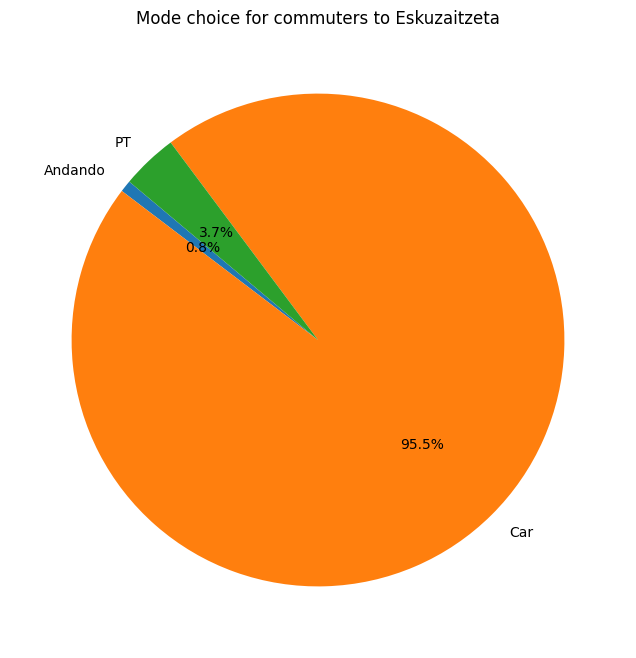

In [842]:
# Change BRT

trips_ez_1 = trips_ez.copy()
trips_ez_1['transit_tt_gm'] = trips_ez_1['transit_tt_gm'] * 1

x = np.array(trips_ez_1.drop(columns = ['Hora_Ini', 'Recur', 'Income', 'Income_Percentile', 'Mun_Des', 'Mun_Ori', 'O_long', 'O_lat', 'D_long', 'D_lat']))
y_pred = model.predict(x)
trips_ez_1['prediction'] = y_pred

unique_labels, counts = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_labels, autopct='%1.1f%%', startangle=140)
plt.title('Mode choice for commuters to Eskuzaitzeta')
plt.show()

In [843]:
trips_ez_1.to_csv(f"results/dfs/{name}.csv")

## CREACIÓN DE ARCHIVOS HEXAGON Y ARCS

In [844]:
# Hexagon

trips_ez_1['COORDINATES'] = trips_ez_1.apply(lambda row: [row['O_long'], row['O_lat']], axis=1)

coordinates_list = trips_ez_1['COORDINATES'].apply(lambda x: {'COORDINATES': x}).tolist()

with open(name_hexagon, 'w') as f:
    json.dump(coordinates_list, f)

In [845]:
# Arcs

def determine_inbound(mode):
    if mode == "Car":
        return 1
    elif mode == "PT":
        return 2
    elif mode == "Andando":
        return 3
    else:
        return 0

json_list = [
    {
        "inbound": determine_inbound(row['prediction']),
        "from": {
            "coordinates": [row['O_long'], row['O_lat']]
        },
        "to": {
            "coordinates": [row['D_long'], row['D_lat']]
        }
    } for index, row in trips_ez_1.iterrows()
]

# Save the JSON structure to a file
with open(name_arc, 'w') as outfile:
    json.dump(json_list, outfile, indent=2)